In [0]:
import numpy as np
import pandas as pd
import keras as keras
from keras import models as models
from keras import layers
import random

data = pd.read_csv("fire_new.csv")
data = data.dropna()
data.head(10)

Using TensorFlow backend.


,Unnamed: 0,OBJECTID,NWCG_REPORTING_UNIT_ID,FIRE_YEAR,Date,Month,Month-Year,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,FIPS_CODE,FIPS_NAME
1657,1658,1146249,USOR981S,2010,2/7/2010,7,7-2010,183,Campfire,0.01,A,42.19417,-121.86333,PRIVATE,OR,35.0,Klamath
1658,1659,1146250,USOR954S,2010,3/7/2010,7,7-2010,184,Equipment Use,0.72,B,45.43694,-121.32639,PRIVATE,OR,65.0,Wasco
1659,1660,1146251,USOR723S,2010,3/7/2010,7,7-2010,184,Campfire,0.01,A,42.06889,-124.31583,MISSING/NOT SPECIFIED,OR,15.0,Curry
1660,1661,1146252,USOR530S,2010,6/7/2010,7,7-2010,187,Campfire,3.12,B,45.26972,-123.39389,PRIVATE,OR,71.0,Yamhill
1661,1662,1146253,USOR551S,2010,6/7/2010,7,7-2010,187,Miscellaneous,0.14,A,44.37694,-123.65806,PRIVATE,OR,3.0,Benton
1662,1663,1146254,USOR553S,2010,6/7/2010,7,7-2010,187,Campfire,0.10,A,44.95194,-124.00361,PRIVATE,OR,41.0,Lincoln
1663,1664,1146255,USOR552S,2010,7/7/2010,7,7-2010,188,Debris Burning,5.40,B,45.09972,-123.68139,PRIVATE,OR,71.0,Yamhill
1664,1665,1146256,USOR771S,2010,9/7/2010,7,7-2010,190,Equipment Use,0.10,A,43.82944,-123.02361,PRIVATE,OR,39.0,Lane
1665,1666,1146257,USOR510S,2010,14/7/2010,7,7-2010,195,Campfire,0.01,A,45.44028,-123.95583,MISSING/NOT SPECIFIED,OR,57.0,Tillamook
1666,1667,1146258,USOR971S,2010,15/7/2010,7,7-2010,196,Campfire,0.05,A,45.40083,-118.12750,COUNTY,OR,61.0,Union


In [0]:
#check number of counties in fire dataset. This is the most granular details in terms of geolocation of the fires.
print(len(data))
len(np.unique(data['FIPS_NAME']))

381359


1652

In [0]:
#because each county name is not unique across the state, we need to join the county to its respective state to have unique values
fire = data.rename(columns={'FIPS_NAME': 'county_name', 'STATE': 'state_id', 'FIRE_YEAR':'Year' })
fire["state_county"] = fire[['state_id','county_name']].agg('-'.join, axis = 1)

In [0]:
mapping = pd.read_csv("mapping.csv")
mapping["state_county"] = mapping[['state_id','county_name']].agg('-'.join, axis = 1)

In [0]:
fire_merged = pd.merge(fire, mapping[['state_name', 'county_fips', 'state_county']], how = "left", on = ['state_county'])
fire_merged.head()

,Unnamed: 0,OBJECTID,NWCG_REPORTING_UNIT_ID,Year,Date,Month,Month-Year,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,state_id,FIPS_CODE,county_name,state_county,state_name,county_fips
0,1658,1146249,USOR981S,2010,2/7/2010,7,7-2010,183,Campfire,0.01,A,42.19417,-121.86333,PRIVATE,OR,35.0,Klamath,OR-Klamath,Oregon,41035.0
1,1659,1146250,USOR954S,2010,3/7/2010,7,7-2010,184,Equipment Use,0.72,B,45.43694,-121.32639,PRIVATE,OR,65.0,Wasco,OR-Wasco,Oregon,41065.0
2,1660,1146251,USOR723S,2010,3/7/2010,7,7-2010,184,Campfire,0.01,A,42.06889,-124.31583,MISSING/NOT SPECIFIED,OR,15.0,Curry,OR-Curry,Oregon,41015.0
3,1661,1146252,USOR530S,2010,6/7/2010,7,7-2010,187,Campfire,3.12,B,45.26972,-123.39389,PRIVATE,OR,71.0,Yamhill,OR-Yamhill,Oregon,41071.0
4,1662,1146253,USOR551S,2010,6/7/2010,7,7-2010,187,Miscellaneous,0.14,A,44.37694,-123.65806,PRIVATE,OR,3.0,Benton,OR-Benton,Oregon,41003.0


In [0]:
#check for NAs and change in dataset. Only about 1,000 data points are loss. okay.
fire_merged = fire_merged.dropna()
print('number of data points remaining are:', len(fire_merged))

number of data points remaining are: 380434


In [0]:
#additional datasets that we managed to get from other sources. For info, these have been pre-cleaned separately
unemployment = pd.read_csv("unemployment.csv")
income = pd.read_csv("income.csv")
temperature = pd.read_csv("temperature.csv")
drought = pd.read_csv("drought_new.csv")
print(income.head())
print(unemployment.head())
print(temperature.head())
print(drought.head())

   FIPS State Area_name  Median_Income
0  1001    AL   Autauga        51868.0
1  1003    AL   Baldwin        47539.0
2  1005    AL   Barbour        30981.0
3  1007    AL      Bibb        39781.0
4  1009    AL    Blount        44392.0
   FIPS State      Area_name  Year  Unemployment_rate
0     0    US  United States  2010                9.6
1  1000    AL        Alabama  2010               10.5
2  1001    AL        Autauga  2010                8.9
3  1003    AL        Baldwin  2010               10.0
4  1005    AL        Barbour  2010               12.3
   Unnamed: 0        dt  Month  Year Month-Year county_name state_id  \
0           1  1/1/1900      1  2011     1-2011       Aiken       SC   
1           2  1/1/1900      1  2011     1-2011     Alachua       FL   
2           3  1/1/1900      1  2011     1-2011     Alameda       CA   
3           4  1/1/1900      1  2011     1-2011  Alexandria       VA   
4           5  1/1/1900      1  2011     1-2011   Allamakee       IA   

   Averag

In [0]:
###########can start by renaming your columns to the main dataset#######

income = income.rename(columns={'Area_name': 'county_name', 'State': 'state_id' })
unemployment = unemployment.rename(columns={'Area_name': 'county_name', 'State': 'state_id' })
 

############Then concatenate state with country as same county names can be found in different state####

income["state_county"] = income[['state_id','county_name']].agg('-'.join, axis = 1)
unemployment["state_county"] = unemployment[['state_id','county_name']].agg('-'.join, axis = 1)
#temperature = temperature.dropna()
#temperature["state_county"] = temperature[['state_id','county_name']].agg('-'.join, axis = 1)
drought["state_county"] = drought[['state_id','county_name']].agg('-'.join, axis = 1)

############Then join test join to main data set and see number of dropouts######

fire_merged = pd.merge(fire_merged, income[['state_county', 'Median_Income']], how = "left", on = ['state_county'])
fire_merged = pd.merge(fire_merged, unemployment[['state_county', 'Unemployment_rate', 'Year']], how = "left", on = ['state_county', 'Year'])
#fire_merged = pd.merge(fire_merged, temperature[['state_county', 'AverageTemperature', 'Month-Year']], how = "left", on = ['state_county', 'Month-Year'])
fire_merged = pd.merge(fire_merged, drought[['state_county', 'Drought', 'Month-Year']], how = "left", on = ['state_county', 'Month-Year'])
fire_merged['Drought'] = fire_merged['Drought'].fillna(0)
fire_merged = fire_merged.dropna()
print(len(fire_merged)) # lost only 3000 data points. Not bad.
fire_merged.groupby('FIRE_SIZE_CLASS').count()
#Majority of fire size is A and B

377429


,Unnamed: 0,OBJECTID,NWCG_REPORTING_UNIT_ID,Year,Date,Month,Month-Year,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,...,OWNER_DESCR,state_id,FIPS_CODE,county_name,state_county,state_name,county_fips,Median_Income,Unemployment_rate,Drought
FIRE_SIZE_CLASS,,,,,,,,,,,,,,,,,,,,,
A,143108,143108,143108,143108,143108,143108,143108,143108,143108,143108,...,143108,143108,143108,143108,143108,143108,143108,143108,143108,143108
B,182078,182078,182078,182078,182078,182078,182078,182078,182078,182078,...,182078,182078,182078,182078,182078,182078,182078,182078,182078,182078
C,41983,41983,41983,41983,41983,41983,41983,41983,41983,41983,...,41983,41983,41983,41983,41983,41983,41983,41983,41983,41983
D,5444,5444,5444,5444,5444,5444,5444,5444,5444,5444,...,5444,5444,5444,5444,5444,5444,5444,5444,5444,5444
E,2599,2599,2599,2599,2599,2599,2599,2599,2599,2599,...,2599,2599,2599,2599,2599,2599,2599,2599,2599,2599
F,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,...,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449
G,768,768,768,768,768,768,768,768,768,768,...,768,768,768,768,768,768,768,768,768,768


In [0]:
#Data Exploration to Understand the Signficant of each variable

#A: income-49511   unemp-8.36   Drought cases- 70%
#B: income-43993   unemp-8.54   Drought cases- 64%
#C: income-41355   unemp-8.55   Drought cases- 61%
#D: income-43010   unemp-8.05   Drought cases- 69%
#E: income-44038   unemp-7.79   Drought cases- 72%
#F: income-45673   unemp-7.55   Drought cases- 77%
#G: income-45558   unemp-7.502  Drought cases- 82%

In [0]:
#####data preparation for running Multilabel Classification model######
from sklearn.utils import shuffle

random.seed(10)
df_copy = fire_merged.drop(['Unnamed: 0','OBJECTID', 'NWCG_REPORTING_UNIT_ID', 'Date', 'DISCOVERY_DOY', 'FIRE_SIZE','FIPS_CODE', 'state_name', 'county_name','state_county','county_fips', 'Year', 'Month-Year', 'Median_Income'], axis = 1)
df_copy = shuffle(df_copy, random_state = 2)

label_cols = ['FIRE_SIZE_CLASS']
num_cols = ['Median_Income', 'Unemployment_rate', 'Drought', 'LATITUDE', 'LONGITUDE']
cat_cols = [i for i in df_copy.columns if i not in num_cols and i not in label_cols]
# One hot encoding for categorical columns
df_copy = pd.get_dummies(data = df_copy, columns = cat_cols, drop_first=True)

df_train = df_copy.sample(frac=0.9, random_state=1)
df_test = df_copy.drop(df_train.index)
y_train = df_train['FIRE_SIZE_CLASS']
y_test = df_test['FIRE_SIZE_CLASS']
x_train = df_train.drop('FIRE_SIZE_CLASS', axis = 1)
x_test = df_test.drop('FIRE_SIZE_CLASS', axis = 1)
x_train.head()

,LATITUDE,LONGITUDE,Unemployment_rate,Drought,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,...,state_id_SD,state_id_TN,state_id_TX,state_id_UT,state_id_VA,state_id_VT,state_id_WA,state_id_WI,state_id_WV,state_id_WY
158110,45.063460,-84.550890,10.7,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
259632,37.533056,-119.391667,11.2,1.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
170514,31.002445,-82.108243,9.3,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58428,33.807644,-81.062714,8.0,1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43128,29.644100,-81.282800,12.4,1.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [0]:
#Scale data and perform PCA
from sklearn.preprocessing import MinMaxScaler

# Scaling for numerical columns for train and test dataset separately
x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()

# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0,1))
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns.values)
x_test_scaled = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns.values)
x_train_scaled.head()

,LATITUDE,LONGITUDE,Unemployment_rate,Drought,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,...,state_id_SD,state_id_TN,state_id_TX,state_id_UT,state_id_VA,state_id_VT,state_id_WA,state_id_WI,state_id_WV,state_id_WY
0,0.858824,0.810640,0.340580,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.610427,0.435132,0.358696,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.395009,0.836966,0.289855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.487541,0.848235,0.242754,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.350203,0.845863,0.402174,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


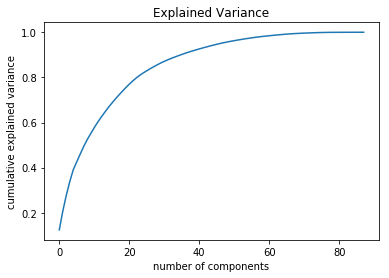

In [0]:
#Dimensionality Reduction
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.figure()
pca = PCA().fit(x_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Explained Variance')
plt.show()

# to retain 90% variance 

In [0]:
# Apply PCA transformation
from sklearn.decomposition import PCA
pca = PCA(n_components = 40) #choose the number of components
pca.fit(x_train_scaled)

x_train_pca = pca.transform(x_train_scaled)
print("original shape:", x_train_scaled.shape)
print("transformed shape:", x_train_pca.shape)

x_test_pca = pca.transform(x_test_scaled)
print("original shape:", x_test_scaled.shape)
print("transformed shape:", x_test_pca.shape)

pca_columns=[]
for i in range(x_train_pca.shape[1]):
   pca_columns.append('pca_'+str(i+1))

x_train = pd.DataFrame(data = x_train_pca, columns = pca_columns)
x_test = pd.DataFrame(data = x_test_pca, columns = pca_columns)

original shape: (339686, 88)
transformed shape: (339686, 40)
original shape: (37743, 88)
transformed shape: (37743, 40)


Running of Models for Multilabel Classification

In [0]:
#Ridge Classifier

from sklearn.linear_model import RidgeClassifierCV

rc_mc = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(x_train, y_train)
rc_mc.score(x_test, y_test)

0.60533078981533

In [0]:
rc_mc_results = rc_mc.predict(x_test)
print(rc_mc_results[0:100])
np.unique(rc_mc_results, return_counts=True)

#can only predict two classes of fire

['A' 'B' 'B' 'A' 'A' 'A' 'A' 'A' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B'
 'A' 'B' 'B' 'B' 'A' 'A' 'A' 'A' 'B' 'B' 'B' 'B' 'B' 'A' 'A' 'B' 'B' 'A'
 'B' 'A' 'A' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'A' 'A' 'B' 'B' 'B' 'B'
 'B' 'A' 'B' 'A' 'B' 'A' 'B' 'B' 'A' 'B' 'A' 'A' 'B' 'B' 'B' 'A' 'A' 'B'
 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'A' 'B' 'A' 'B' 'A' 'B' 'A' 'A' 'B'
 'A' 'A' 'B' 'B' 'B' 'A' 'B' 'A' 'B' 'B']
['A' 'B']


In [0]:
#Ridge Classifier multilabel confusion matrix

from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, rc_mc_results)

In [0]:
#SVM - RBF Kernel

from sklearn.svm import SVC

svm = SVC(kernel='rbf')
svm.fit(x_train, y_train)
svm.score(x_test, y_test)

In [0]:
#SVM - RBF predictions with multilabel confusion matrix
y_pred_svm = svm.predict(x_test)
np.unique(y_pred_svm, return_counts=True)
multilabel_confusion_matrix(y_test, y_pred_svm)

In [0]:
#SVM - Linear Kernel

from sklearn.svm import SVC

svm_linear = SVC(kernel='linear')
svm_linear.fit(x_train, y_train)
svm_linear.score(x_test, y_test)

In [0]:
#SVM - Linear predictions with multilabel confusion matrix
y_pred_svml = svm_linear.predict(x_test)
np.unique(y_pred_svml, return_counts=True)
multilabel_confusion_matrix(y_test, y_pred_svml)

In [0]:
#Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

rf_mc = RandomForestClassifier(max_depth=10, random_state=0, n_estimators = 200, criterion = 'gini')
rf_mc.fit(x_train, y_train)
rf_mc.score(x_test, y_test)

0.6305275150359007

In [0]:
#Random Forest Classifier predictions with multilabel confusion matrix
rf_mc_results = rf_mc.predict(x_test)
print(rf_mc_results[0:100])
print(np.unique(rf_mc_results))
#can only predict 3 classes of fire

multilabel_confusion_matrix(y_test, rf_mc_results)

['A' 'B' 'B' 'B' 'A' 'A' 'A' 'A' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B'
 'A' 'B' 'B' 'B' 'A' 'A' 'A' 'A' 'B' 'B' 'B' 'B' 'A' 'A' 'B' 'B' 'B' 'A'
 'B' 'A' 'A' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'A' 'B' 'A' 'B' 'B' 'B' 'B'
 'B' 'A' 'B' 'A' 'B' 'A' 'B' 'B' 'A' 'B' 'A' 'B' 'B' 'B' 'B' 'B' 'A' 'B'
 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'A' 'B' 'A' 'B' 'A' 'B' 'A' 'A' 'B'
 'A' 'A' 'B' 'B' 'B' 'A' 'B' 'B' 'B' 'B']
['A' 'B' 'C']


In [0]:
####try using a basic MLPClassifier
from sklearn.neural_network import MLPClassifier

mlpc_mc = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001)
mlpc_mc.fit(x_train, y_train)
mlpc_mc.score(x_test, y_test)


0.6350846514585486

In [0]:
mlpc_mc_results = mlpc_mc.predict(x_test)
print(mlpc_mc_results[0:100])
print(np.unique(mlpc_mc_results))

#can predict all 7 classes of fire

['A' 'B' 'B' 'B' 'B' 'A' 'A' 'A' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B'
 'A' 'B' 'B' 'B' 'A' 'A' 'A' 'A' 'B' 'B' 'B' 'B' 'B' 'A' 'B' 'C' 'B' 'A'
 'B' 'A' 'A' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'A' 'B' 'A' 'B' 'B' 'B' 'B'
 'B' 'A' 'B' 'B' 'B' 'A' 'B' 'B' 'A' 'B' 'B' 'A' 'B' 'B' 'B' 'B' 'A' 'B'
 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'A' 'B' 'A' 'B' 'A' 'B' 'A' 'A' 'B'
 'A' 'A' 'B' 'B' 'B' 'A' 'B' 'B' 'B' 'B']
['A' 'B' 'C' 'D' 'E' 'F' 'G']


In [0]:
##### Additional data preparation for running MLP using Keras######

from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce
#ce_encodex = ce.OrdinalEncoder(cols=['STAT_CAUSE_DESCR', 'OWNER_DESCR', 'state_id'])
#x_train = ce_encodex.fit_transform(x_train)
#x_test = ce_encodex.fit_transform(x_test)
ce_encodey = ce.OrdinalEncoder(cols=['FIRE_SIZE_CLASS'])
y_train = ce_encodey.fit_transform(y_train)
y_test = ce_encodey.fit_transform(y_test)

In [0]:
from keras.utils import to_categorical
x_train = np.array(x_train)
print(x_train.shape)
x_test = np.array(x_test)
print(x_test.shape)
y_train = np.array(y_train)
y_train = to_categorical(y_train)
print(y_train.shape)
y_test = np.array(y_test)
y_test = to_categorical(y_test)
print(y_test.shape)

(339686, 40)
(37743, 40)
(339686, 8)
(37743, 8)


In [0]:
#running the model for regression for classification

model = models.Sequential()
model.add(layers.Dense(units=256, activation="relu", input_shape=(x_train.shape[1],)))
model.add(layers.Dense(units=256, activation="relu"))
model.add(layers.Dense(units=128, activation="relu"))
model.add(layers.Dense(8, activation='softmax'))

In [0]:
model.compile(loss="categorical_crossentropy", # Cross-entropy
                optimizer=keras.optimizers.Adam(0.00005), 
                metrics=["accuracy"])

In [0]:
history = model.fit(x_train,
                    y_train,
                    batch_size =128,
                    epochs=100,
                    class_weight = class_weight,
                    validation_data=(x_test, y_test))

Train on 339686 samples, validate on 37743 samples
Epoch 1/100
339686/339686 [==============================] - 7s 21us/step - loss: 1.0049 - accuracy: 0.6019 - val_loss: 0.9294 - val_accuracy: 0.6142
Epoch 2/100
339686/339686 [==============================] - 7s 21us/step - loss: 0.9184 - accuracy: 0.6236 - val_loss: 0.9177 - val_accuracy: 0.6202
Epoch 3/100
339686/339686 [==============================] - 7s 21us/step - loss: 0.9093 - accuracy: 0.6282 - val_loss: 0.9143 - val_accuracy: 0.6208
Epoch 4/100
339686/339686 [==============================] - 7s 20us/step - loss: 0.9043 - accuracy: 0.6308 - val_loss: 0.9091 - val_accuracy: 0.6246
Epoch 5/100
339686/339686 [==============================] - 7s 20us/step - loss: 0.9006 - accuracy: 0.6327 - val_loss: 0.9057 - val_accuracy: 0.6267
Epoch 6/100
339686/339686 [==============================] - 7s 20us/step - loss: 0.8976 - accuracy: 0.6338 - val_loss: 0.9068 - val_accuracy: 0.6252
Epoch 7/100
339686/339686 [======================

Epoch 55/100
339686/339686 [==============================] - 8s 24us/step - loss: 0.8607 - accuracy: 0.6483 - val_loss: 0.8811 - val_accuracy: 0.6363
Epoch 56/100
339686/339686 [==============================] - 8s 25us/step - loss: 0.8603 - accuracy: 0.6486 - val_loss: 0.8820 - val_accuracy: 0.6364
Epoch 57/100
339686/339686 [==============================] - 8s 25us/step - loss: 0.8601 - accuracy: 0.6480 - val_loss: 0.8806 - val_accuracy: 0.6376
Epoch 58/100
339686/339686 [==============================] - 10s 30us/step - loss: 0.8597 - accuracy: 0.6484 - val_loss: 0.8821 - val_accuracy: 0.6360
Epoch 59/100
339686/339686 [==============================] - 9s 26us/step - loss: 0.8594 - accuracy: 0.6487 - val_loss: 0.8808 - val_accuracy: 0.6365
Epoch 60/100
339686/339686 [==============================] - 9s 28us/step - loss: 0.8591 - accuracy: 0.6481 - val_loss: 0.8822 - val_accuracy: 0.6353
Epoch 61/100
339686/339686 [==============================] - 10s 30us/step - loss: 0.8589 - 

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, recall_score

test_results = model.predict_classes(x_test)
print(test_results[0:100])
print(np.unique(test_results))

#able to predict all 7 classes of fire with higher accuracy

[1 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 1 1 1 2 2 2 2 2 1 2 2 2 1 2
 1 1 2 2 2 2 2 2 2 2 1 2 1 2 2 1 2 2 2 2 1 2 1 2 2 1 2 2 1 2 2 2 2 1 2 2 2
 2 2 2 2 2 2 2 1 2 1 2 1 2 1 1 2 1 1 2 2 2 1 2 2 2 2]
[1 2 3 4 5 6 7]


In [0]:
#as the results for multilabel is not that good especially at predicting large fires, 
#to consider using binary. This is also because it is more important to identify bigger fires.

#note that we also do downsampling so as to make the different classes more balance. 

####downsampling before running the model####

from sklearn.utils import resample

fire_mergedA = fire_merged[fire_merged.FIRE_SIZE_CLASS == 'A'] #drought 70% temp 17.1 income  55368  unemp: 9.3
fire_mergedB = fire_merged[fire_merged.FIRE_SIZE_CLASS == 'B'] #drought 68% temp 17.9   income 52116  unempl: 9.1
fire_mergedC = fire_merged[fire_merged.FIRE_SIZE_CLASS == 'C'] #drought 65% temp 19.1   income 48989  unemp: 9.1
fire_mergedD = fire_merged[fire_merged.FIRE_SIZE_CLASS == 'D'] #drought 63%  temp 21    income 49769  unemp: 9.6
fire_mergedE = fire_merged[fire_merged.FIRE_SIZE_CLASS == 'E'] #drought 72% temp 22.5   income 47949   unemp: 9.8
fire_mergedF = fire_merged[fire_merged.FIRE_SIZE_CLASS == 'F'] # drought 77% temp 20.8  income 49202   unemp: 9.4
fire_mergedG = fire_merged[fire_merged.FIRE_SIZE_CLASS == 'G'] # drought 90%  temp 21 income 52883

fire_mergedA = resample(fire_mergedA, replace= False, n_samples = 25000)
fire_mergedB = resample(fire_mergedB, replace= False, n_samples = 25000)
fire_mergedC = resample(fire_mergedC, replace= False, n_samples = 41983)
fire_mergedD = resample(fire_mergedD, replace= False, n_samples = 5444)
fire_mergedE = resample(fire_mergedE, replace= False, n_samples = 2599)
fire_mergedF = resample(fire_mergedF, replace= False, n_samples = 1449)

fire_merged = pd.concat([fire_mergedA,fire_mergedB,fire_mergedC,fire_mergedD,fire_mergedE, fire_mergedF,fire_mergedG])

In [0]:
fire_merged.shape

(102243, 23)

In [0]:
#Labelling as Binary Classification Instead#
# Consider changing the definition of big fire#
#since we have less data now, can use state-county instead of latitude and longitude

random.seed(10)
df_copy = fire_merged.drop(['Unnamed: 0','OBJECTID', 'NWCG_REPORTING_UNIT_ID', 'Date', 'DISCOVERY_DOY', 'FIRE_SIZE','FIPS_CODE', 'state_name', 'county_name','county_fips', 'Year', 'Month-Year', 'Median_Income', 'LATITUDE', 'LONGITUDE'], axis = 1)
df_copy = shuffle(df_copy, random_state = 2)

label_cols = ['FIRE_SIZE_CLASS']
num_cols = ['Median_Income', 'Unemployment_rate', 'Drought']
cat_cols = [i for i in df_copy.columns if i not in num_cols and i not in label_cols]
# One hot encoding for categorical columns
df_copy = pd.get_dummies(data = df_copy, columns = cat_cols, drop_first=True)

df_train = df_copy.sample(frac=0.9, random_state=1)
df_test = df_copy.drop(df_train.index)
y_train = df_train['FIRE_SIZE_CLASS']
y_test = df_test['FIRE_SIZE_CLASS']
x_train = df_train.drop('FIRE_SIZE_CLASS', axis = 1)
x_test = df_test.drop('FIRE_SIZE_CLASS', axis = 1)
x_train.head()


,Unemployment_rate,Drought,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,...,state_county_WY-Niobrara,state_county_WY-Park,state_county_WY-Platte,state_county_WY-Sheridan,state_county_WY-Sublette,state_county_WY-Sweetwater,state_county_WY-Teton,state_county_WY-Uinta,state_county_WY-Washakie,state_county_WY-Weston
371963,4.2,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
345282,3.9,0.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243339,7.8,1.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
231406,6.1,1.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86946,7.7,0.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [0]:
#Scale data and perform PCA
from sklearn.preprocessing import MinMaxScaler

# Scaling for numerical columns for train and test dataset separately
x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()

# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0,1))
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns.values)
x_test_scaled = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns.values)
x_train_scaled.head()

,Unemployment_rate,Drought,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,...,state_county_WY-Niobrara,state_county_WY-Park,state_county_WY-Platte,state_county_WY-Sheridan,state_county_WY-Sublette,state_county_WY-Sweetwater,state_county_WY-Teton,state_county_WY-Uinta,state_county_WY-Washakie,state_county_WY-Weston
0,0.105072,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.094203,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.235507,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.173913,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.231884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


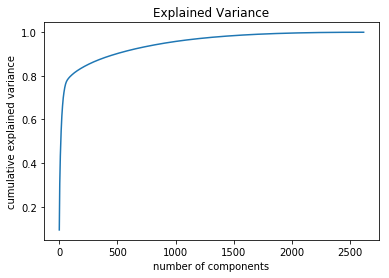

In [0]:
#Dimensionality Reduction
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.figure()
pca = PCA().fit(x_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Explained Variance')
plt.show()

# to retain 90% variance 

In [0]:
# Apply PCA transformation

pca = PCA(n_components = 600) #choose the number of components
pca.fit(x_train_scaled)

x_train_pca = pca.transform(x_train_scaled)
print("original shape:", x_train_scaled.shape)
print("transformed shape:", x_train_pca.shape)

x_test_pca = pca.transform(x_test_scaled)
print("original shape:", x_test_scaled.shape)
print("transformed shape:", x_test_pca.shape)

pca_columns=[]
for i in range(x_train_pca.shape[1]):
   pca_columns.append('pca_'+str(i+1))

x_train = pd.DataFrame(data = x_train_pca, columns = pca_columns)
x_test = pd.DataFrame(data = x_test_pca, columns = pca_columns)

original shape: (92019, 2617)
transformed shape: (92019, 600)
original shape: (10224, 2617)
transformed shape: (10224, 600)


In [0]:
y_train = pd.DataFrame(df_train['FIRE_SIZE_CLASS'])
y_test = pd.DataFrame(df_test['FIRE_SIZE_CLASS'])
y_train["Class"] = y_train["FIRE_SIZE_CLASS"].apply(lambda x: "1" if x in ["C", "D","E", "F", "G"] else "0")
y_test["Class"] = y_test["FIRE_SIZE_CLASS"].apply(lambda x: "1" if x in ["C", "D","E", "F", "G"] else "0")
y_train = y_train['Class'].astype(int)
y_test = y_test['Class'].astype(int)

Running of Models for Binary Classification

In [0]:
#Ridge Classifier

from sklearn.linear_model import RidgeClassifierCV

rc_bn = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(x_train, y_train)
rc_bn.score(x_test, y_test)

0.7108763693270735

In [0]:
rc_bn_results = rc_bn.predict(x_test)
print('actual number of big fire = ',sum(y_test))
print('predicted number of big fire = ',sum(rc_bn_results))
test_accuracy_score = accuracy_score(y_test, rc_bn_results)
print('test accuracy = ',test_accuracy_score)
print(classification_report(y_test, rc_bn_results))

actual number of big fire =  5206
predicted number of big fire =  5570
test accuracy =  0.7108763693270735
              precision    recall  f1-score   support

           0       0.72      0.67      0.69      5018
           1       0.70      0.75      0.73      5206

    accuracy                           0.71     10224
   macro avg       0.71      0.71      0.71     10224
weighted avg       0.71      0.71      0.71     10224



In [0]:
### SVM linear binary ###
from sklearn.metrics import accuracy_score
from sklearn import svm

# fit the training dataset on the classifier

classifier=svm.SVC(kernel='linear', gamma='auto')
classifier.fit(x_train, y_train)

pred = classifier.predict(x_test)

accuracy = accuracy_score(pred, y_test)
print("Accuracy of classification = ", accuracy)

In [0]:
#print('actual number of big fire = ',sum(y_test))
#print('predicted number of big fire = ',sum(pred))
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, recall_score
test_accuracy_score = accuracy_score(y_test, pred)
print('test accuracy = ',test_accuracy_score)
print(classification_report(y_test, pred))

In [0]:
#SVM note that this will take about 3-4 hours to run

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

svm_bn = OneVsRestClassifier(SVC(kernel='rbf'))
svm_bn.fit(x_train, y_train)
svm_bn.score(x_test, y_test)

0.7282863849765259

In [0]:
svm_bn_results = svm_bn.predict(x_test)
print('actual number of big fire = ',sum(y_test))
print('predicted number of big fire = ',sum(svm_bn_results))
test_accuracy_score = accuracy_score(y_test, svm_bn_results)
print('test accuracy = ',test_accuracy_score)
print(classification_report(y_test, svm_bn_results))

actual number of big fire =  5206
predicted number of big fire =  5590
test accuracy =  0.7282863849765259
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      5018
           1       0.72      0.77      0.74      5206

    accuracy                           0.73     10224
   macro avg       0.73      0.73      0.73     10224
weighted avg       0.73      0.73      0.73     10224



In [0]:
#####running model for random forest####
#####with added variables####

from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier

class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

rf_bn = RandomForestClassifier(max_depth=10, random_state=0, n_estimators = 150, class_weight='balanced')
rf_bn.fit(x_train, y_train)
rf_bn.score(x_test, y_test)

0.7160602503912363

In [0]:
rf_bn_results = rf_bn.predict(x_test)
print('actual number of big fire = ',sum(y_test))
print('predicted number of big fire = ',sum(rf_bn_results))
test_accuracy_score = accuracy_score(y_test, rf_bn_results)
print('test accuracy = ',test_accuracy_score)
print(classification_report(y_test, rf_bn_results))

actual number of big fire =  5206
predicted number of big fire =  5719
test accuracy =  0.7160602503912363
              precision    recall  f1-score   support

           0       0.73      0.66      0.70      5018
           1       0.70      0.77      0.73      5206

    accuracy                           0.72     10224
   macro avg       0.72      0.72      0.71     10224
weighted avg       0.72      0.72      0.72     10224



In [0]:
####try using a basic MLPClassifier
from sklearn.neural_network import MLPClassifier

mlpc_bn = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001)
mlpc_bn.fit(x_train, y_train)
mlpc_bn.score(x_test, y_test)

C:\Users\tgy24\Anaconda2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.7006064162754304

In [0]:
mlpc_bn_results = mlpc_bn.predict(x_test)
print('actual number of big fire = ',sum(y_test))
print('predicted number of big fire = ',sum(mlpc_bn_results))
test_accuracy_score = accuracy_score(y_test, mlpc_bn_results)
print('test accuracy = ',test_accuracy_score)
print(classification_report(y_test, mlpc_bn_results))

actual number of big fire =  5206
predicted number of big fire =  5141
test accuracy =  0.7006064162754304
              precision    recall  f1-score   support

           0       0.69      0.70      0.70      5018
           1       0.71      0.70      0.70      5206

    accuracy                           0.70     10224
   macro avg       0.70      0.70      0.70     10224
weighted avg       0.70      0.70      0.70     10224



In [0]:
#running the model for regression for Binary classification

model = models.Sequential()
model.add(layers.Dense(units=256, activation="relu", input_shape=(x_train.shape[1],)))
model.add(layers.Dense(units=256, activation="relu"))
model.add(layers.Dense(units=128, activation="relu"))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", # Cross-entropy
                optimizer=keras.optimizers.Adam(0.00005),  
                metrics=["accuracy"])

In [0]:
history = model.fit(x_train,
                    y_train,
                    batch_size =64,
                    epochs=10,
                    validation_data=(x_test, y_test))

Train on 92019 samples, validate on 10224 samples
Epoch 1/10
92019/92019 [==============================] - 5s 55us/step - loss: 0.6057 - accuracy: 0.6712 - val_loss: 0.5567 - val_accuracy: 0.7157
Epoch 2/10
92019/92019 [==============================] - 5s 53us/step - loss: 0.5492 - accuracy: 0.7186 - val_loss: 0.5463 - val_accuracy: 0.7211
Epoch 3/10
92019/92019 [==============================] - 6s 66us/step - loss: 0.5385 - accuracy: 0.7254 - val_loss: 0.5427 - val_accuracy: 0.7204
Epoch 4/10
92019/92019 [==============================] - 8s 89us/step - loss: 0.5319 - accuracy: 0.7303 - val_loss: 0.5406 - val_accuracy: 0.7251
Epoch 5/10
92019/92019 [==============================] - 9s 96us/step - loss: 0.5269 - accuracy: 0.7335 - val_loss: 0.5396 - val_accuracy: 0.7242
Epoch 6/10
92019/92019 [==============================] - 8s 87us/step - loss: 0.5221 - accuracy: 0.7367 - val_loss: 0.5378 - val_accuracy: 0.7248
Epoch 7/10
92019/92019 [==============================] - 8s 87us/st

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, recall_score
test_results = model.predict_classes(x_test)
print('actual number of big fire = ',sum(y_test))
print('predicted number of big fire = ',sum(test_results))
test_accuracy_score = accuracy_score(y_test, test_results)
print('test accuracy = ',test_accuracy_score)
print(classification_report(y_test, test_results))

actual number of big fire =  5206
predicted number of big fire =  [5654]
test accuracy =  0.7280907668231612
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      5018
           1       0.71      0.78      0.74      5206

   micro avg       0.73      0.73      0.73     10224
   macro avg       0.73      0.73      0.73     10224
weighted avg       0.73      0.73      0.73     10224

